# Imports

In [1]:
# data pre-processing
import pickle
import numpy as np
import pandas as pd
from epiweeks import Week
from datetime import timedelta
import os

# pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [16,8]

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *

### uncomment if adding new data

In [2]:
# add new data

# new_data = {'Surveillance Week':[47],
#             'A(H1N1)pdm09':[119],
#             'A(H3N2)':	[2214],
#             'A(Unsubtyped)':[5424],
#             'Influenza B':[16],
#             'Percent Positive A':[23.1],
#             'Percent Positive B':[0.0]}

In [3]:
# add new data

# new_data_df = pd.DataFrame.from_dict(new_data)
# new_data_df = new_data_df.iloc[:,0:5]
# for i in range(len(new_data_df)):
#     if int(new_data_df['Surveillance Week'][i]) >= 35 & int(new_data_df['Surveillance Week'][i]) <= 53:
#         new_data_df['Year'] = "2022"
#     else:
#         new_data_df['Year'] = "2023"

# sum_list = new_data_df.columns[1:5]
# new_data_df['Total Cases'] = new_data_df[sum_list].sum(axis=1)
# new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].astype(int).astype(str)
# new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].str.pad(2, fillchar='0')
# new_data_df['Year'] = new_data_df['Year'].astype(int).astype(str)
# new_data_df['Epiweek'] = new_data_df['Year'] + new_data_df['Surveillance Week'].astype(str)
# new_data_df['Week Ending'] = new_data_df['Epiweek'].apply(lambda x: Week.fromstring(x).enddate())
# new_data_df['Week Ending'] = pd.to_datetime(new_data_df['Week Ending'], format="%Y-%m-%d")

# df_flu = pickle.load(open(r"..\data\flu_cases\df_flu.pkl", "rb" ))
# # df_flu = pd.concat([df_flu, new_data_df], axis=0)
# # df_flu = df_flu.reset_index(drop=True)
# df_flu.loc[len(df_flu.index)] = np.nan
# df_flu['Week Ending'].iloc[-1] = df_flu['Week Ending'].iloc[-2] + timedelta(weeks=1)
# df_flu['Week Ending'].iloc[-1]
# pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu.pkl", "wb" ))
# df_flu = df_flu[['Week Ending', 'Total Cases']]
# df_flu = df_flu.set_index('Week Ending')
# pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu_total.pkl", "wb" ))

### run model on existing data

In [4]:
# use existing data
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

# add next three weeks to predict as well
df_flu['y2'] = df_flu['Total Cases'].shift(-1)
df_flu['y3'] = df_flu['Total Cases'].shift(-2)
df_flu['y4'] = df_flu['Total Cases'].shift(-3)
df_flu.rename(columns={'Total Cases':'y1'}, inplace=True)

# extract year, month and week
# df_flu = df_flu.set_index('Week Ending')
df_flu['year'] = df_flu.index.year
df_flu['month'] = df_flu.index.month

# df_flu['week'] = df_flu.index.isocalendar().week

# add season
season_dict = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'}
df_flu["season"] = df_flu["month"].map(season_dict)

# include 7 lag features (based on autocorrelation plot showing significant autocorrelation for 7 previous values)
arr_list = []
for i in range(1,8):
    arr_list.append(df_flu['y1'].shift(i).to_numpy())

col_names = [*range(1,8)]
new_col_names = []
for name in col_names:
    name = 't - ' + str(name)
    new_col_names.append(name)
df = pd.DataFrame.from_dict(dict(zip(new_col_names, arr_list)))
df_flu = df_flu.reset_index(drop=True)
df_flu = pd.concat([df_flu, df], axis=1)

# same week from previous year
df_flu['this week last year'] = df_flu['y1'].shift(52)

# use 2-week moving average (based on EDA - simplifies the pattern without losing too much data)
df_flu['two-week moving average'] = df_flu['t - 1'].rolling(window=2).mean()

# expanding mean
df_flu['expanding mean'] = df_flu['t - 1'].expanding().mean()

pickle.dump(df_flu, open(r"..\data\flu_cases\df_time_features.pkl", "wb" ))

In [5]:
# get health indicators
df_indicators = pd.read_csv(r'..\data\health_indicators\health_indicators_2015_2021.csv', skiprows=12)

# Drop nulls because they are only showing on the rows without data
df_indicators.dropna(inplace=True)

# Null values in the data are represented with '..'
df_indicators = df_indicators.replace('..', np.nan)
df_indicators = df_indicators.T
more_than_half_missing = df_indicators.isnull().sum() >= 4
more_than_half_missing = pd.DataFrame(more_than_half_missing)
idx_to_drop = list(more_than_half_missing[more_than_half_missing[0]==True].index.values)

# drop rows
df_indicators = df_indicators.T
df_indicators = df_indicators.drop(index=idx_to_drop)
df_indicators = df_indicators.reset_index(drop=True)

# convert values to numeric values
df_indicators = df_indicators.replace(',','', regex=True)
df_indicators = df_indicators.set_index('Indicators')
df_indicators = df_indicators.apply(pd.to_numeric)

# fill nulls with the mean value from the row
df_indicators = df_indicators.apply(lambda row: row.fillna(row.mean()), axis=1)
df_indicators.reset_index()
df_indicators = df_indicators.T
df_indicators = df_indicators.reset_index()
df_indicators['index'] = df_indicators['index'].astype(int)

# add a row for 2022 and shift all the values forward one year because we will use previous year's value to predict current years flu cases
df_indicators.loc[len(df_indicators.index)] = 2022
df_indicators.iloc[:,1:] = df_indicators.iloc[:,1:].shift(1)

# merge health indicators with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

years = [x.year for x in df_flu.index]

X = np.array([years]).T
dates = pd.DataFrame(X, columns = ['year'])

df_flu = df_flu.reset_index(drop=True)
df_flu = pd.concat([dates, df_flu], axis=1)

df_health_indicators = pd.merge(df_flu, df_indicators, how='left', left_on=['year'], right_on=['index'])

pickle.dump(df_health_indicators, open(r"..\data\health_indicators\df_health_indicators.pkl", "wb" ))

In [6]:
# get a list of table names
table_list_flu = os.listdir(r"..\data\google_trend\flu")

# create a dictionary with table names as keys and dataframes as values
dict_flu = {}
datapath = r'..\data\google_trend\flu'

for i in range(len(table_list_flu)):
    df = pd.read_csv(datapath+'\\'+table_list_flu[i], header=1)
    dict_flu[table_list_flu[i][13:-4]] = df

# create a dataframe with one column for each symptom
df_flu_symptoms = pd.DataFrame({'Month':dict_flu['body_aches']['Month']}) # get the month values from one of the dataframes
df_flu_symptoms.loc[len(df_flu_symptoms.index)] = '2022-12'

for key in dict_flu:
    df_flu_symptoms[key] = dict_flu[key].iloc[:,1] # retrieve values from each dataframe

df_flu_symptoms.iloc[:,1:] = df_flu_symptoms.iloc[:,1:].shift(1)

df_flu_symptoms['Month'] = pd.to_datetime(df_flu_symptoms['Month'])
df_flu_symptoms.set_index('Month', inplace=True)

# get month and year to be able to merge with df_flu
months = [x.month for x in df_flu_symptoms.index]
years = [x.year for x in df_flu_symptoms.index]
X = np.array([months, years]).T
dates = pd.DataFrame(X, columns = ['month', 'year'])
df_flu_symptoms = df_flu_symptoms.reset_index(drop=True)
df_flu_symptoms = pd.concat([dates, df_flu_symptoms], axis=1)

# merge flu symptoms with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

months = [x.month for x in df_flu.index]
years = [x.year for x in df_flu.index]
weeks = [x.weekofyear for x in df_flu.index]

X = np.array([months, years, weeks]).T
df = pd.DataFrame(X, columns = ['month', 'year', 'week'])

df_flu = df_flu.reset_index(drop=True)
new = pd.concat([df_flu, df], axis=1)

df_flu_symptoms = pd.merge(new, df_flu_symptoms, how='left', on=['month','year'])

pickle.dump(df_flu_symptoms, open(r"..\data\google_trend\df_flu_symptoms.pkl", "wb" ))

In [7]:
# get a list of table names
table_list_COVID = os.listdir(r"..\data\google_trend\COVID")

# create a dictionary with table names as keys and dataframes as values
dict_COVID = {}
datapath = r'..\data\google_trend\COVID'

for i in range(len(table_list_COVID)):
    df = pd.read_csv(datapath+'\\'+table_list_COVID[i], header=1)
    dict_COVID[table_list_COVID[i][13:-4]] = df

# create a dataframe with one column for each symptom
df_COVID_terms = pd.DataFrame({'Month':dict_COVID['coronavirus']['Month']})
df_COVID_terms.loc[len(df_COVID_terms.index)] = '2022-12'

for key in dict_COVID:
    df_COVID_terms[key] = dict_COVID[key].iloc[:,1]

df_COVID_terms.iloc[:,1:] = df_COVID_terms.iloc[:,1:].shift(1)

df_COVID_terms = df_COVID_terms.replace('<1',0.5)

df_COVID_terms[['coronavirus', 'COVID', 'social_distancing']] = df_COVID_terms[['coronavirus', 'COVID', 'social_distancing']].apply(pd.to_numeric)

df_COVID_terms['Month'] = pd.to_datetime(df_COVID_terms['Month'])
df_COVID_terms.set_index('Month', inplace=True)

# get month and year to be able to merge with df_flu
months = [x.month for x in df_COVID_terms.index]
years = [x.year for x in df_COVID_terms.index]
X = np.array([months, years]).T
dates = pd.DataFrame(X, columns = ['month', 'year'])
df_COVID_terms = df_COVID_terms.reset_index(drop=True)
df_COVID_terms = pd.concat([dates, df_COVID_terms], axis=1)

# merge COVID symptoms with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

months = [x.month for x in df_flu.index]
years = [x.year for x in df_flu.index]
weeks = [x.weekofyear for x in df_flu.index]

X = np.array([months, years, weeks]).T
df = pd.DataFrame(X, columns = ['month', 'year', 'week'])

df_flu = df_flu.reset_index(drop=True)
new = pd.concat([df_flu, df], axis=1)

df_COVID_terms = pd.merge(new, df_COVID_terms, how='left', on=['month','year'])

pickle.dump(df_COVID_terms, open(r"..\data\google_trend\df_COVID_terms.pkl", "wb" ))

In [96]:
df_health_indicators = pickle.load(open(r"..\data\health_indicators\df_health_indicators.pkl", "rb" ))
df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_air_travel = pickle.load(open(r"..\data\mobility\df_air_travel.pkl", "rb" ))
# df_urban_transit = pickle.load(open(r"..\data\mobility\df_urban_transit.pkl", "rb" ))

In [97]:
df_list = [df_time_features, df_health_indicators, df_flu_symptoms, df_COVID_terms, ]
df = pd.concat(df_list, axis=1)
df = df.loc[:,~df.columns.duplicated()]
df = df.drop(columns=['Total Cases','index','week','year'])

# last row to make prediction on
df_to_predict = df.iloc[-1,4:]
df_to_predict = pd.DataFrame(df_to_predict).T

df = df.dropna()

In [98]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

cat_feats = list(train_X[['month','season']].astype(str).columns)
num_feats = list(train_X.drop(columns=['month','season']).columns)

features = train_X.columns

In [101]:
test_y['y1'].values

array([2.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
       1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 6.000e+00,
       4.000e+00, 6.000e+00, 1.900e+01, 2.000e+01, 2.000e+01, 2.700e+01,
       4.500e+01, 4.300e+01, 3.600e+01, 4.400e+01, 2.500e+01, 2.300e+01,
       2.300e+01, 8.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 2.000e+00,
       1.000e+01, 1.600e+01, 1.800e+01, 2.600e+01, 8.500e+01, 2.280e+02,
       3.700e+02, 5.470e+02, 1.114e+03, 1.740e+03, 2.102e+03, 2.196e+03,
       1.679e+03, 1.516e+03, 1.323e+03, 9.940e+02, 6.500e+02, 3.800e+02,
       2.950e+02, 1.460e+02, 7.700e+01, 7.000e+01, 

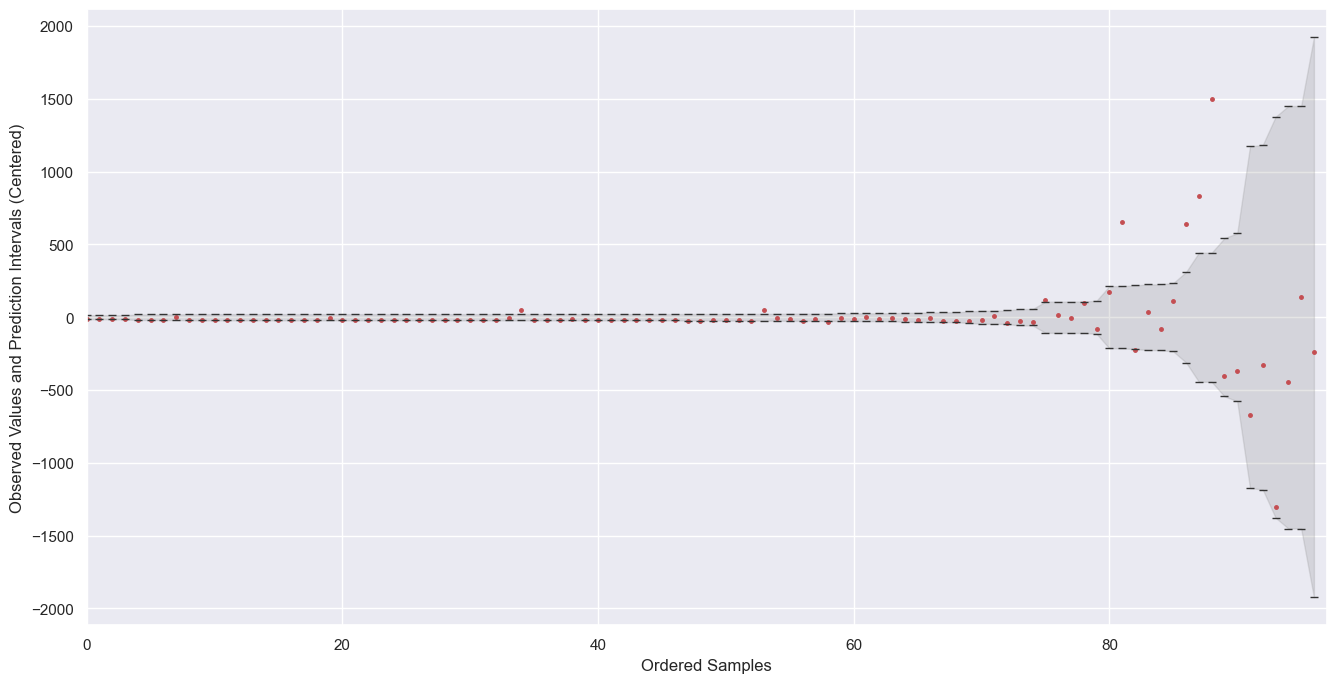

Score:  1.0
Score:  0.7343150228851025
MSE:  69332.83762886598


In [109]:
from quantile_forest import RandomForestQuantileRegressor

numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
    (categorical_transform, cat_feats),
    (numeric_transform, num_feats),   
    remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessing', ct), 
                          ('model', RandomForestQuantileRegressor(n_estimators=100, random_state=2023))])

pipeline.fit(train_X, train_y['y1'])

# Get predictions at 95% prediction intervals and median.
y_pred = pipeline.predict(test_X, quantiles=[0.025, 0.5, 0.975])


def plot_intervals(y_true, y_pred_lower, y_pred_upper):
    # fig = plt.figure(figsize=(10, 4))
    plt.figure()
    y_pred_interval = y_pred_upper - y_pred_lower
    sort_idx = np.argsort(y_pred_interval)
    y_true = y_true[sort_idx]
    y_pred_lower = y_pred_lower[sort_idx]
    y_pred_upper = y_pred_upper[sort_idx]

    # Center data, with the mean of the prediction interval at 0.
    mean = (y_pred_lower + y_pred_upper) / 2
    y_true -= mean
    y_pred_lower -= mean
    y_pred_upper -= mean

    plt.plot(y_true, marker='.', ms=5, c='r', lw=0)
    plt.fill_between(
        np.arange(len(y_pred_upper)),
        y_pred_lower,
        y_pred_upper,
        alpha=0.2,
        color='gray',
    )
    plt.plot(np.arange(len(y_true)), y_pred_lower, marker='_', c='0.2', lw=0)
    plt.plot(np.arange(len(y_true)), y_pred_upper, marker='_', c='0.2', lw=0)
    plt.xlim([0, len(y_true)])
    plt.xlabel('Ordered Samples')
    plt.ylabel('Observed Values and Prediction Intervals (Centered)')

    plt.show()


plot_intervals(test_y['y1'].values, y_pred[:, 0], y_pred[:, 2])

print('Score: ', r2_score(train_y['y1'].values, pipeline.predict(train_X)))
print('Score: ', r2_score(test_y['y1'], y_pred[:, 1]))
print('MSE: ', mean_squared_error(test_y['y1'], y_pred[:, 1]))

In [110]:
y_pred = pd.DataFrame(y_pred)

In [111]:
y_pred = y_pred.rename(columns={0:'y_pred_lower',1:'y_pred_median',2:'y_pred_upper'})

In [115]:
y_pred['actual'] = test_y['y1'].values

In [116]:
y_pred

,y_pred_lower,y_pred_median,y_pred_upper,actual
0,0.000,4.0,46.00,2.0
1,0.000,4.0,46.00,0.0
2,0.000,4.0,46.00,5.0
3,0.000,4.0,45.05,0.0
4,0.000,4.0,45.05,0.0
...,...,...,...,...
92,23.425,173.0,238.00,149.0
93,23.425,175.0,238.00,251.0
94,93.300,278.0,563.30,438.0
95,161.000,362.0,588.80,1031.0


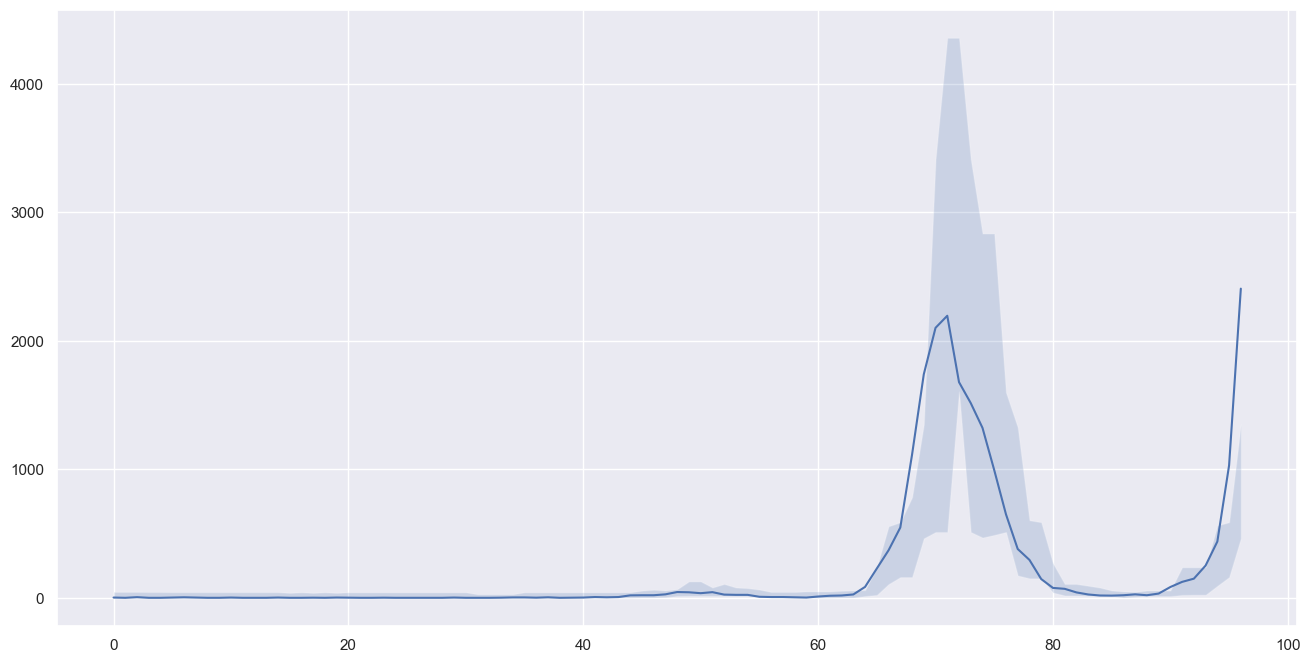

In [119]:
fig, ax = plt.subplots()
ax.plot(y_pred.index, y_pred['actual'], '-')
ax.fill_between(y_pred.index, y_pred['y_pred_lower'], y_pred['y_pred_upper'], alpha=0.2)
# ax.plot(x, y, 'o', color='tab:brown')

<AxesSubplot: >

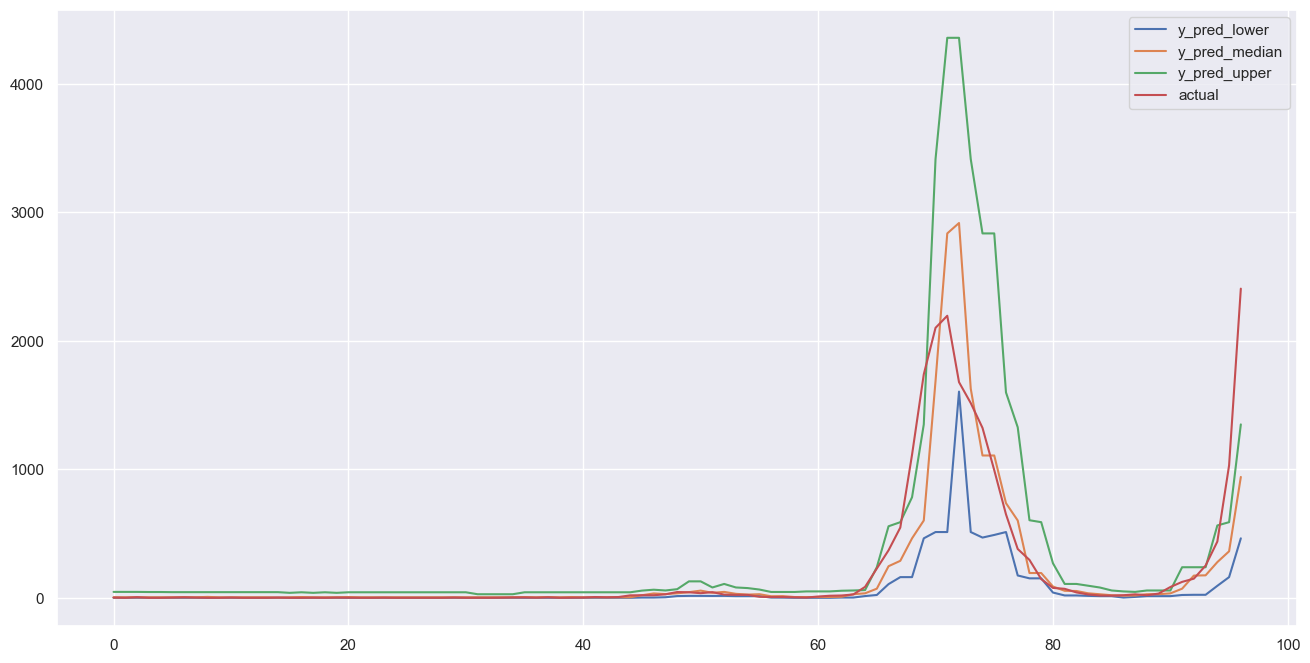

In [117]:
y_pred.plot()

,Model,Dataset,Weeks-ahead Forecast,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822
0,RF_test_2,Full Dataset,3,11496.91,944775.26,107.22,972.0,54.51,658.07,0.993432,-0.362659
0,RF_test_2,Full Dataset,4,12663.29,1495838.86,112.53,1223.04,56.55,823.48,0.992766,-0.187358
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822
0,RF_test_2,Full Dataset,3,11496.91,944775.26,107.22,972.0,54.51,658.07,0.993432,-0.362659
0,RF_test_2,Full Dataset,4,12663.29,1495838.86,112.53,1223.04,56.55,823.48,0.992766,-0.187358
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822


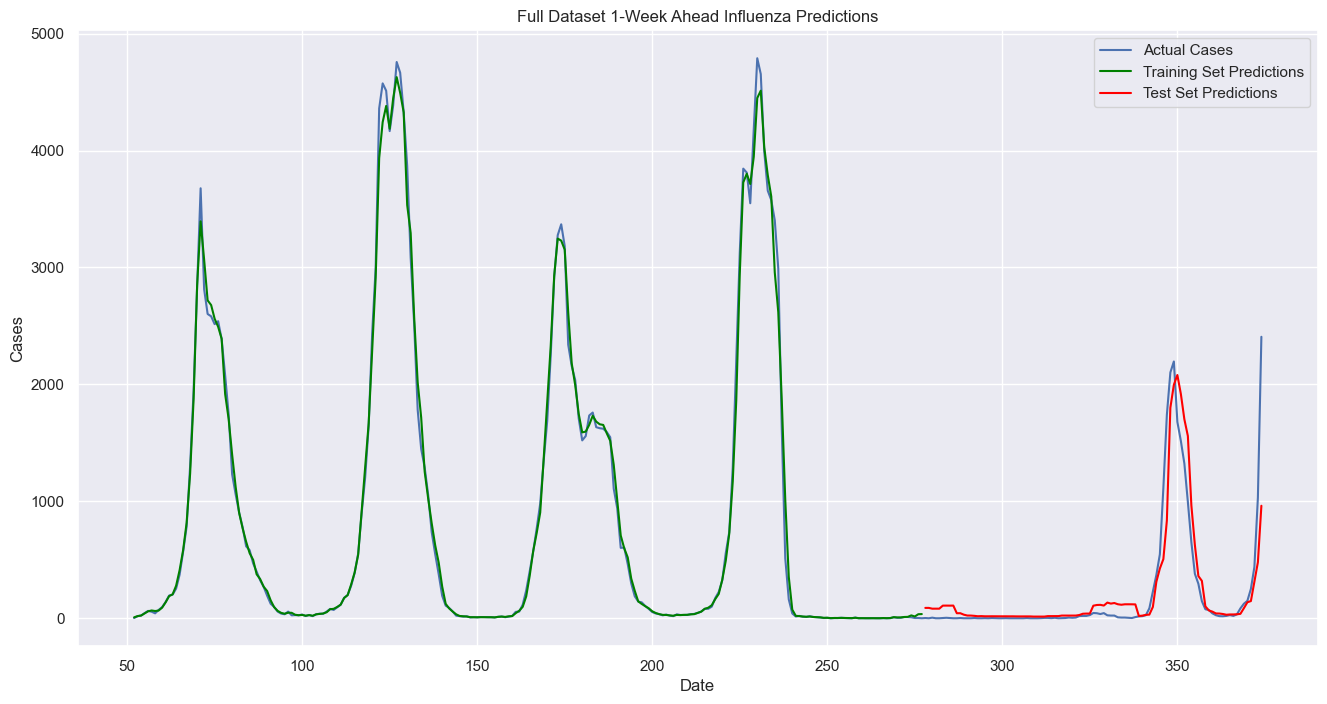

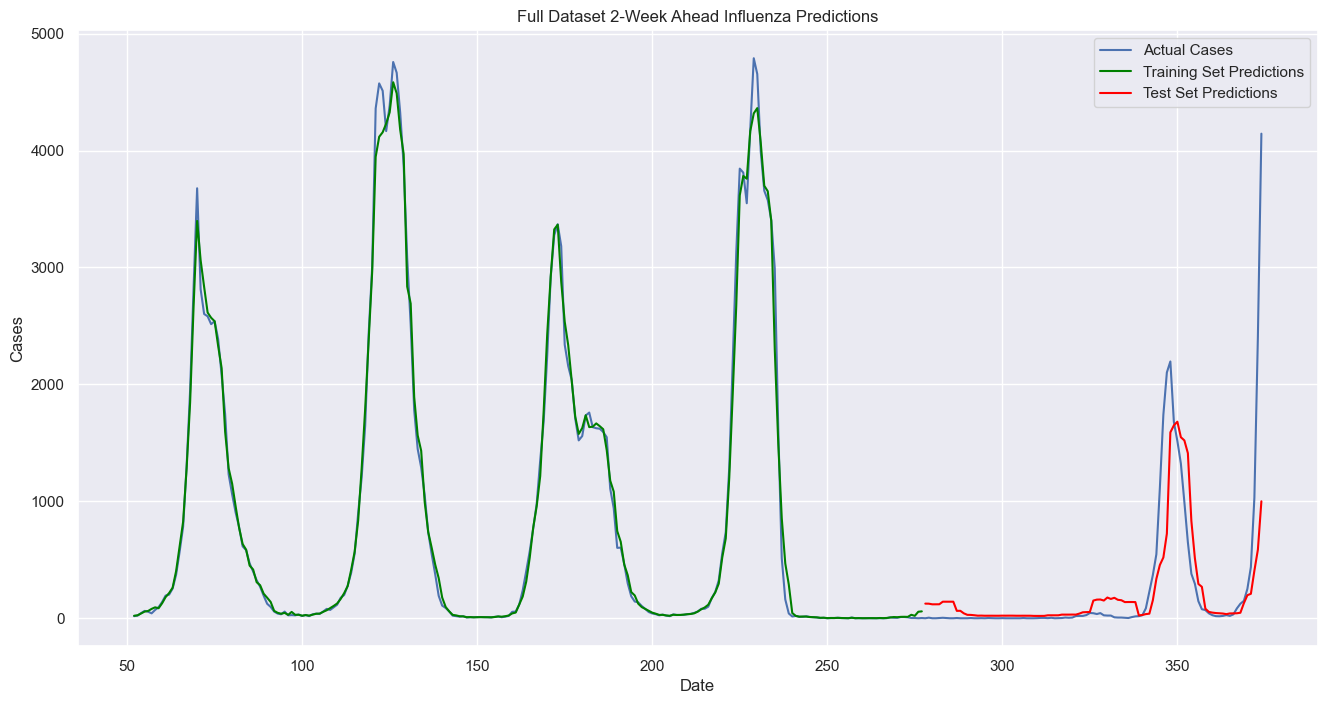

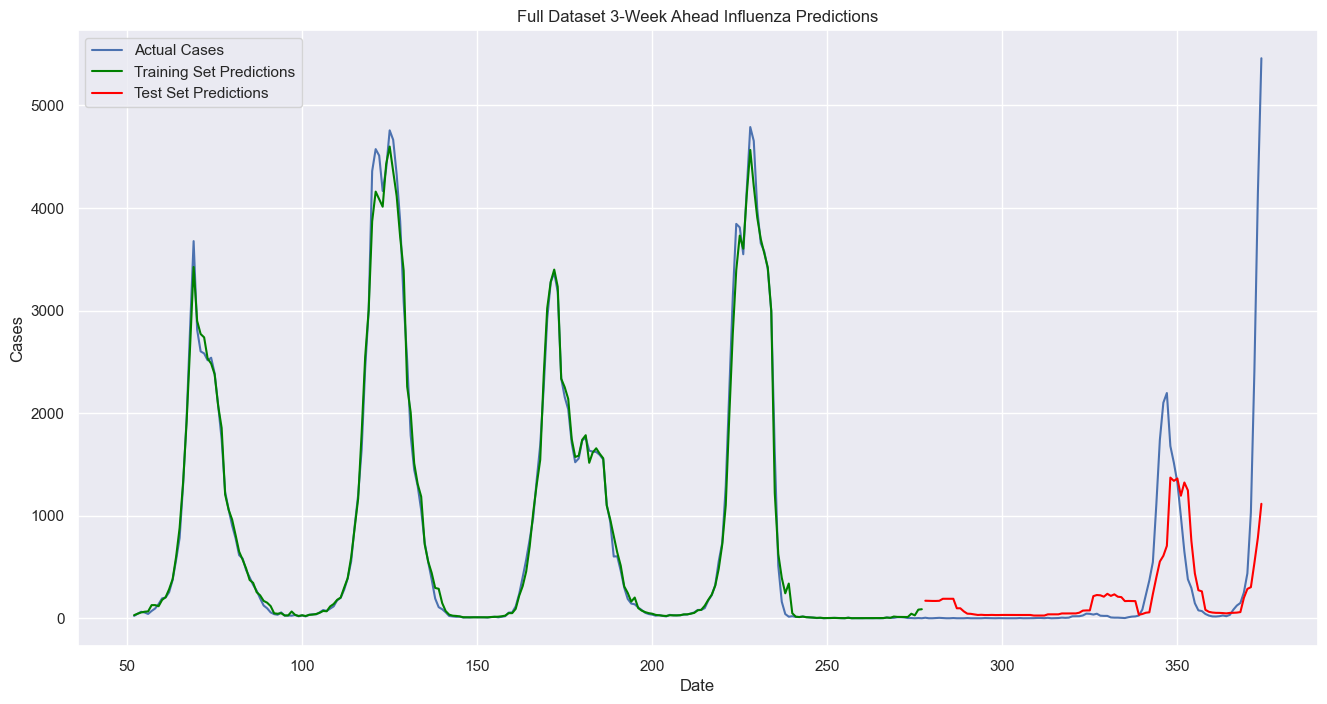

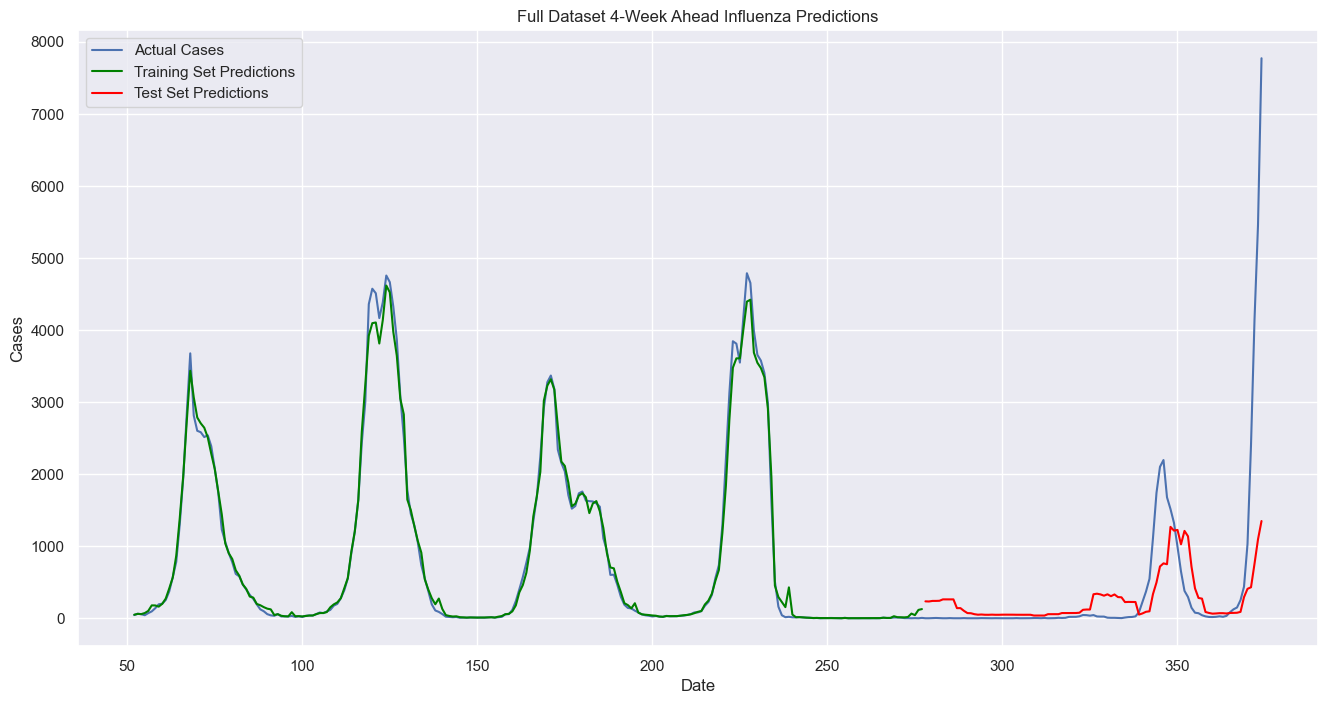

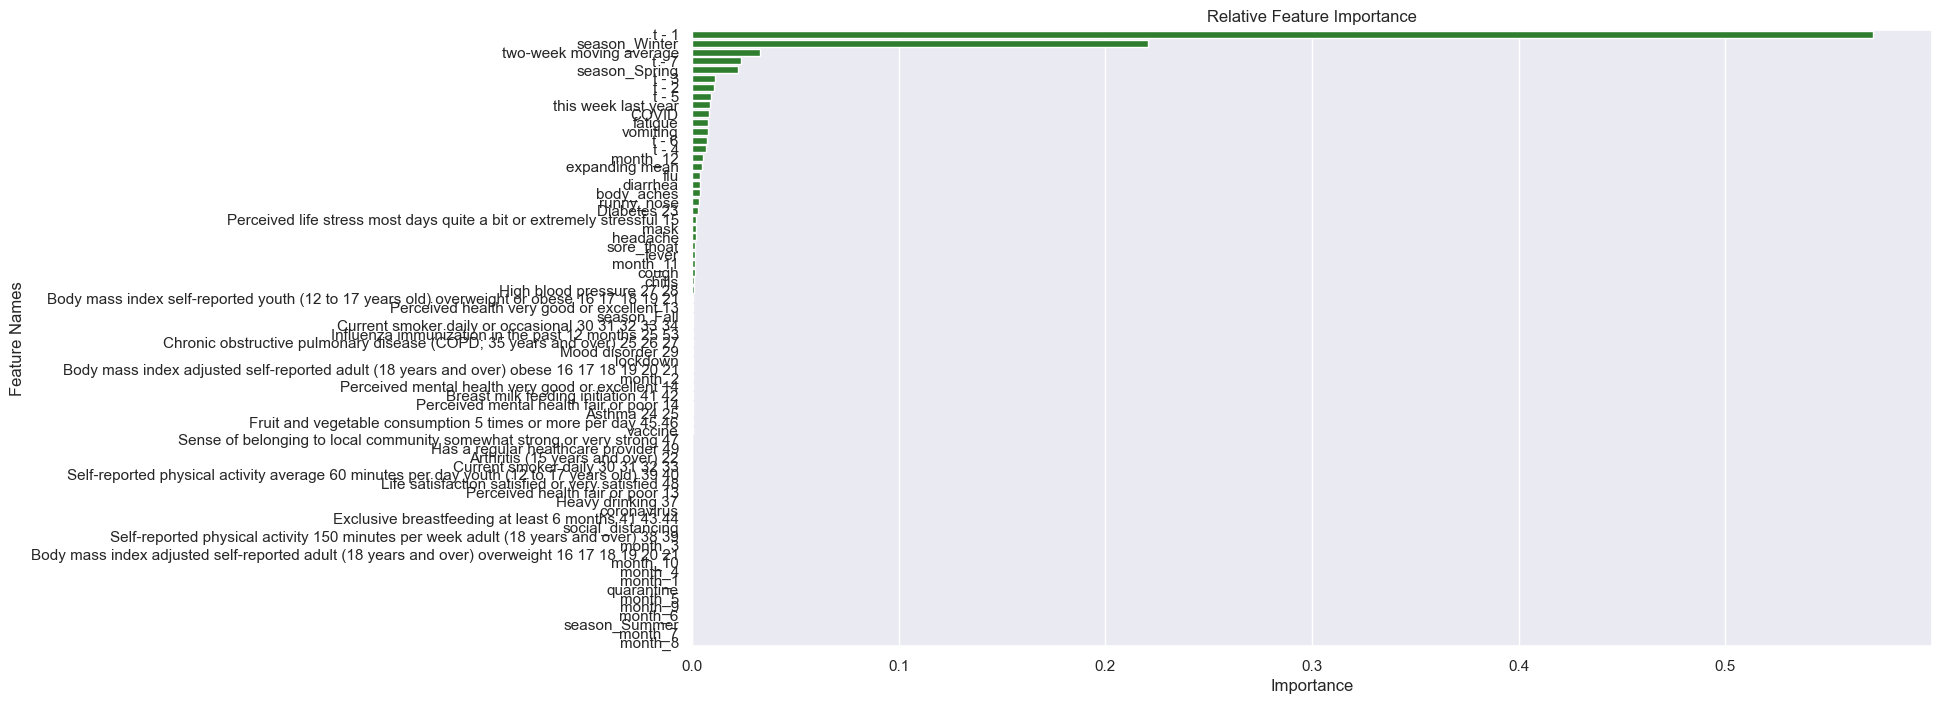

In [11]:
numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
    (categorical_transform, cat_feats),
    (numeric_transform, num_feats),   
    remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessing', ct), 
                          ('model', RandomForestRegressor(random_state=2023))])

pipeline.fit(train_X, train_y)

preds_test = pipeline.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = pipeline.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

dataset = 'Full Dataset'
model = 'RF_test_2'

for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset=dataset, forecast_weeks=i, model=model)

# plot
week = 1
for target in preds_train_df.columns:
    plt.figure()
    plt.plot(df.index, df[target].values, label='Actual Cases')
    plt.plot(df.index[:train_size], preds_train_df[target], color='green', label='Training Set Predictions')
    plt.plot(df.index[train_size:], preds_test_df[target], color='red', label='Test Set Predictions')
    plt.title(f'{dataset} {week}-Week Ahead Influenza Predictions')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    week += 1

# get feature importances from the model
# referenced https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
importance = pipeline.steps[1][1].feature_importances_
names = pipeline[:-1].get_feature_names_out()

df = pd.DataFrame({'Feature Names':names,'Importance':importance, })
df = df.sort_values(by='Importance', ascending = False)
df[['dtype','Feature Names']] = df['Feature Names'].str.split("__",expand=True)
df = df.drop(columns='dtype')
plt.figure()
sns.barplot(data=df, x='Importance', y='Feature Names', orient='h', color='forestgreen').set(title='Relative Feature Importance')

results_matrix

In [12]:
preds_future = pipeline.predict(df_to_predict)
preds_future_df = pd.DataFrame(np.round(preds_future),columns=test_y.columns)
preds_future_df = preds_future_df.rename(columns={'y1':'1-Week Forecast','y2':'2-Week Forecast','y3':'3-Week Forecast','y4':'4-Week Forecast'})

df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))
dates = df_flu.index

from datetime import timedelta
dates = dates + timedelta(weeks=3)

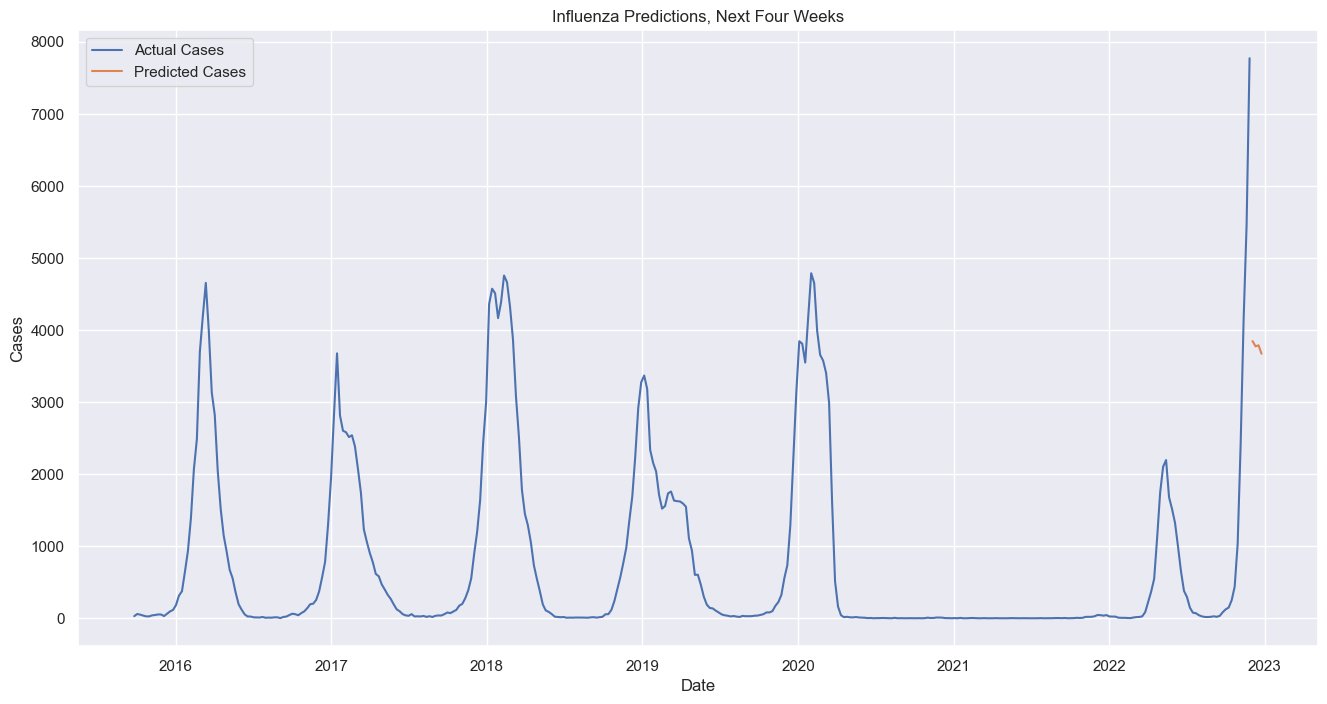

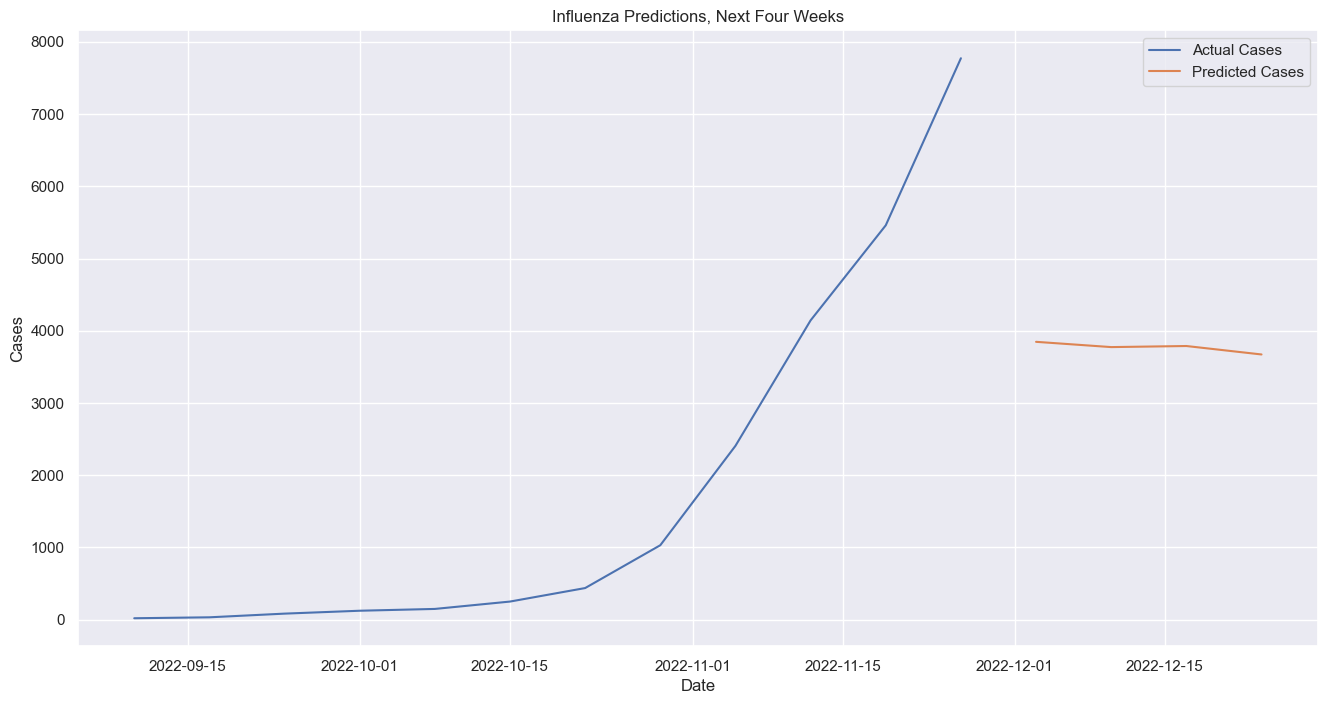

In [13]:
# all dates
plt.figure()
plt.plot(dates[:-4], df_flu[3:-1].values, label='Actual Cases')
plt.plot(dates[-4:], preds_future_df.iloc[0,:].values, label='Predicted Cases')
plt.title(f'Influenza Predictions, Next Four Weeks')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()

# zoom plot
plt.figure()
plt.plot(dates[-16:-4], df_flu.iloc[-13:-1].values, label='Actual Cases')
plt.plot(dates[-4:], preds_future_df.iloc[0,:].values, label='Predicted Cases')
plt.title(f'Influenza Predictions, Next Four Weeks')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()

In [37]:
train_X[150:200]

,month,season,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,this week last year,...,runny_nose,sore_thoat,vomiting,coronavirus,COVID,lockdown,mask,quarantine,social_distancing,vaccine
202,7,Summer,41.0,53.0,80.0,105.0,136.0,143.0,188.0,8.0,...,23.0,35.0,60.0,0.5,0.5,1.0,14.0,1.0,0.0,1.0
203,7,Summer,35.0,41.0,53.0,80.0,105.0,136.0,143.0,10.0,...,23.0,35.0,60.0,0.5,0.5,1.0,14.0,1.0,0.0,1.0
204,8,Summer,25.0,35.0,41.0,53.0,80.0,105.0,136.0,10.0,...,15.0,30.0,62.0,0.0,0.0,1.0,15.0,1.0,0.0,1.0
205,8,Summer,31.0,25.0,35.0,41.0,53.0,80.0,105.0,9.0,...,15.0,30.0,62.0,0.0,0.0,1.0,15.0,1.0,0.0,1.0
206,8,Summer,23.0,31.0,25.0,35.0,41.0,53.0,80.0,9.0,...,15.0,30.0,62.0,0.0,0.0,1.0,15.0,1.0,0.0,1.0
207,8,Summer,18.0,23.0,31.0,25.0,35.0,41.0,53.0,7.0,...,15.0,30.0,62.0,0.0,0.0,1.0,15.0,1.0,0.0,1.0
208,8,Summer,33.0,18.0,23.0,31.0,25.0,35.0,41.0,12.0,...,15.0,30.0,62.0,0.0,0.0,1.0,15.0,1.0,0.0,1.0
209,9,Fall,28.0,33.0,18.0,23.0,31.0,25.0,35.0,15.0,...,17.0,26.0,62.0,0.5,0.0,1.0,16.0,1.0,0.0,1.0
210,9,Fall,28.0,28.0,33.0,18.0,23.0,31.0,25.0,9.0,...,17.0,26.0,62.0,0.5,0.0,1.0,16.0,1.0,0.0,1.0
211,9,Fall,29.0,28.0,28.0,33.0,18.0,23.0,31.0,14.0,...,17.0,26.0,62.0,0.5,0.0,1.0,16.0,1.0,0.0,1.0


In [39]:
preds_test[0][0]

88.45

In [50]:
test_y[80:80+1].iloc[:,0]

80    77.0
Name: actual_y1, dtype: float64

In [ ]:
# https://towardsdatascience.com/time-series-forecasting-prediction-intervals-360b1bf4b085

In [54]:
crossval_count = 10
min_size = 150
max_random = len(train_X) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    print(start)
    print(end)
#     pipeline.fit(train_X[start:end], train_y[start:end])

#     preds_test = pipeline.predict(test_X)[0][0]

#     crossval_resids.append(preds_test - test_y[end:end+1].iloc[:,0])
    
# # bsed_residuals = sorted(crossval_resids)
# crossval_resids

51
215
23
178
9
204
17
219
41
211
9
197
22
210
12
213
28
188
47
204


In [80]:
crossval_count = 10
min_size = 20
max_random = len(test_y) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    print(start, end)
    pipeline.fit(train_X[start:end], train_y[start:end])

    preds_test = pipeline.predict(test_X)[0][0]
    print(preds_test)

    crossval_resids.append(preds_test - test_y[end:end+1].iloc[:,0].values)
    print(crossval_resids)
    
# bsed_residuals = sorted(crossval_resids)
crossval_resids

66 96


ValueError: Found unknown categories [7, 8, 9, 10, 11] in column 0 during transform

In [81]:
pipeline.fit(train_X[66:96], train_y[66:96])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['month', 'season']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7',
                                                   'this week last year',
                                                   'two-week moving average',
                                                   'expanding mean',
                                                   '...
                                                   'Current smoker daily or '
                                                   'occasional 30 31 32 33 34',
                                                   'Current smoker daily 30 31 '
                                                   '32 33',
                                                   'Heavy drinking 37',
                                                   'Self-reported physical '
                                                   'activity 150 minutes per '
                                                   'week adult (18 years and '
                                                   'over) 38 39',
                                                   'Self-reported physical '
                                                   'activity average 60 '
                                                   'minutes per day youth (12 '
                                                   'to 17 years old) 39 40',
                                                   'Breast milk feeding '
                                                   'initiation 41 42', ...])])),
                ('model', RandomForestRegressor(random_state=2023))])

In [85]:
test_X

,month,season,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,this week last year,...,runny_nose,sore_thoat,vomiting,coronavirus,COVID,lockdown,mask,quarantine,social_distancing,vaccine
278,1,Winter,0.0,2.0,2.0,8.0,10.0,10.0,4.0,3845.0,...,44.0,34.0,63.0,7.0,74.0,100.0,40.0,25.0,6.0,21.0
279,1,Winter,2.0,0.0,2.0,2.0,8.0,10.0,10.0,3811.0,...,44.0,34.0,63.0,7.0,74.0,100.0,40.0,25.0,6.0,21.0
280,1,Winter,0.0,2.0,0.0,2.0,2.0,8.0,10.0,3549.0,...,44.0,34.0,63.0,7.0,74.0,100.0,40.0,25.0,6.0,21.0
281,1,Winter,5.0,0.0,2.0,0.0,2.0,2.0,8.0,4182.0,...,44.0,34.0,63.0,7.0,74.0,100.0,40.0,25.0,6.0,21.0
282,1,Winter,0.0,5.0,0.0,2.0,0.0,2.0,2.0,4789.0,...,44.0,34.0,63.0,7.0,74.0,100.0,40.0,25.0,6.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,10,Fall,124.0,84.0,33.0,20.0,27.0,20.0,17.0,2.0,...,65.0,63.0,71.0,0.5,11.0,3.0,20.0,7.0,1.0,9.0
371,10,Fall,149.0,124.0,84.0,33.0,20.0,27.0,20.0,6.0,...,65.0,63.0,71.0,0.5,11.0,3.0,20.0,7.0,1.0,9.0
372,10,Fall,251.0,149.0,124.0,84.0,33.0,20.0,27.0,4.0,...,65.0,63.0,71.0,0.5,11.0,3.0,20.0,7.0,1.0,9.0
373,10,Fall,438.0,251.0,149.0,124.0,84.0,33.0,20.0,6.0,...,65.0,63.0,71.0,0.5,11.0,3.0,20.0,7.0,1.0,9.0


In [84]:
preds_test = pipeline.predict(test_X)
print(preds_test)

ValueError: Found unknown categories [7, 8, 9, 10, 11] in column 0 during transform

In [72]:
pipeline.fit(train_X[19:68], train_y[19:68])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['month', 'season']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7',
                                                   'this week last year',
                                                   'two-week moving average',
                                                   'expanding mean',
                                                   '...
                                                   'Current smoker daily or '
                                                   'occasional 30 31 32 33 34',
                                                   'Current smoker daily 30 31 '
                                                   '32 33',
                                                   'Heavy drinking 37',
                                                   'Self-reported physical '
                                                   'activity 150 minutes per '
                                                   'week adult (18 years and '
                                                   'over) 38 39',
                                                   'Self-reported physical '
                                                   'activity average 60 '
                                                   'minutes per day youth (12 '
                                                   'to 17 years old) 39 40',
                                                   'Breast milk feeding '
                                                   'initiation 41 42', ...])])),
                ('model', RandomForestRegressor(random_state=2023))])

In [73]:
preds_test = pipeline.predict(test_X)[0][0]

In [62]:
preds_test = pipeline.predict(test_X)[0][0]

In [74]:
preds_test

1250.76

In [67]:
test_y.iloc[0,0]

2.0

In [69]:
len(test_y)

97

In [77]:
test_y[68:69].iloc[:,0].values

array([1114.])

In [78]:
preds_test - test_y[68:69].iloc[:,0].values

array([136.76])

In [55]:
len(train_X)

226

In [53]:
crossval_resids

[Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype: float64),
 Series([], Name: actual_y1, dtype

In [21]:
preds_test_df = preds_test_df.rename(columns={'y1':'predicted_y1','y2':'predicted_y2','y3':'predicted_y3','y4':'predicted_y4'})
preds_test_df

,predicted_y1,predicted_y2,predicted_y3,predicted_y4
0,88.45,125.09,170.71,234.67
1,88.52,124.54,169.76,232.70
2,81.77,119.14,168.72,240.52
3,82.00,119.28,168.58,240.67
4,81.91,119.65,170.07,242.51
...,...,...,...,...
92,136.67,197.06,285.98,408.25
93,146.87,209.09,303.20,430.20
94,312.24,406.78,537.68,755.98
95,478.66,586.74,785.59,1095.53


In [16]:
test_y = test_y.reset_index(drop=True)

In [18]:
test_y = test_y.rename(columns={'y1':'actual_y1','y2':'actual_y2','y3':'actual_y3','y4':'actual_y4'})

In [20]:
test_y

,actual_y1,actual_y2,actual_y3,actual_y4
0,2.0,0.0,5.0,0.0
1,0.0,5.0,0.0,0.0
2,5.0,0.0,0.0,2.0
3,0.0,0.0,2.0,4.0
4,0.0,2.0,4.0,2.0
...,...,...,...,...
92,149.0,251.0,438.0,1031.0
93,251.0,438.0,1031.0,2407.0
94,438.0,1031.0,2407.0,4144.0
95,1031.0,2407.0,4144.0,5460.0


In [22]:
residuals = pd.concat([test_y, preds_test_df], axis=1)
residuals

,actual_y1,actual_y2,actual_y3,actual_y4,predicted_y1,predicted_y2,predicted_y3,predicted_y4
0,2.0,0.0,5.0,0.0,88.45,125.09,170.71,234.67
1,0.0,5.0,0.0,0.0,88.52,124.54,169.76,232.70
2,5.0,0.0,0.0,2.0,81.77,119.14,168.72,240.52
3,0.0,0.0,2.0,4.0,82.00,119.28,168.58,240.67
4,0.0,2.0,4.0,2.0,81.91,119.65,170.07,242.51
...,...,...,...,...,...,...,...,...
92,149.0,251.0,438.0,1031.0,136.67,197.06,285.98,408.25
93,251.0,438.0,1031.0,2407.0,146.87,209.09,303.20,430.20
94,438.0,1031.0,2407.0,4144.0,312.24,406.78,537.68,755.98
95,1031.0,2407.0,4144.0,5460.0,478.66,586.74,785.59,1095.53


In [24]:
residuals['residuals_y1'] = residuals['actual_y1'] - residuals['predicted_y1']

In [26]:
residuals['residuals_y2'] = residuals['actual_y2'] - residuals['predicted_y2']

In [27]:
residuals['residuals_y3'] = residuals['actual_y3'] - residuals['predicted_y3']

In [28]:
residuals['residuals_y4'] = residuals['actual_y4'] - residuals['predicted_y4']

In [29]:
residuals

,actual_y1,actual_y2,actual_y3,actual_y4,predicted_y1,predicted_y2,predicted_y3,predicted_y4,residuals_y1,residuals_y2,residuals_y3,residuals_y4
0,2.0,0.0,5.0,0.0,88.45,125.09,170.71,234.67,-86.45,-125.09,-165.71,-234.67
1,0.0,5.0,0.0,0.0,88.52,124.54,169.76,232.70,-88.52,-119.54,-169.76,-232.70
2,5.0,0.0,0.0,2.0,81.77,119.14,168.72,240.52,-76.77,-119.14,-168.72,-238.52
3,0.0,0.0,2.0,4.0,82.00,119.28,168.58,240.67,-82.00,-119.28,-166.58,-236.67
4,0.0,2.0,4.0,2.0,81.91,119.65,170.07,242.51,-81.91,-117.65,-166.07,-240.51
...,...,...,...,...,...,...,...,...,...,...,...,...
92,149.0,251.0,438.0,1031.0,136.67,197.06,285.98,408.25,12.33,53.94,152.02,622.75
93,251.0,438.0,1031.0,2407.0,146.87,209.09,303.20,430.20,104.13,228.91,727.80,1976.80
94,438.0,1031.0,2407.0,4144.0,312.24,406.78,537.68,755.98,125.76,624.22,1869.32,3388.02
95,1031.0,2407.0,4144.0,5460.0,478.66,586.74,785.59,1095.53,552.34,1820.26,3358.41,4364.47


<AxesSubplot: >

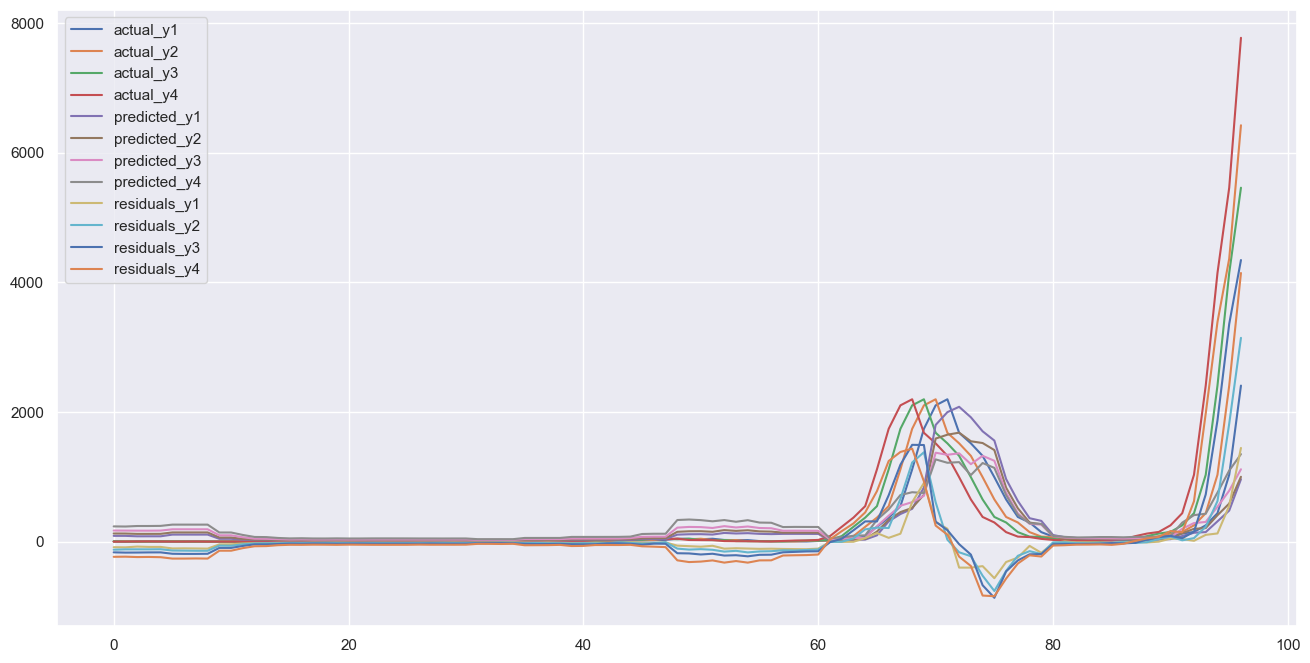

In [30]:
residuals.plot()

In [34]:
residuals.columns[-4:]

Index(['residuals_y1', 'residuals_y2', 'residuals_y3', 'residuals_y4'], dtype='object')

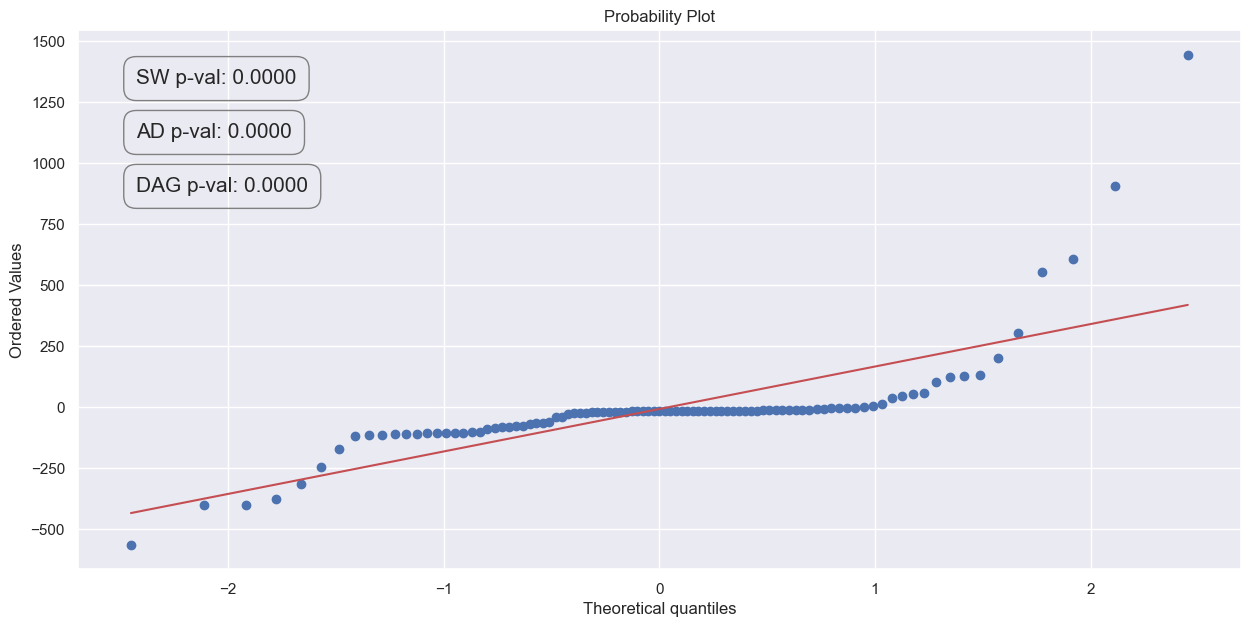

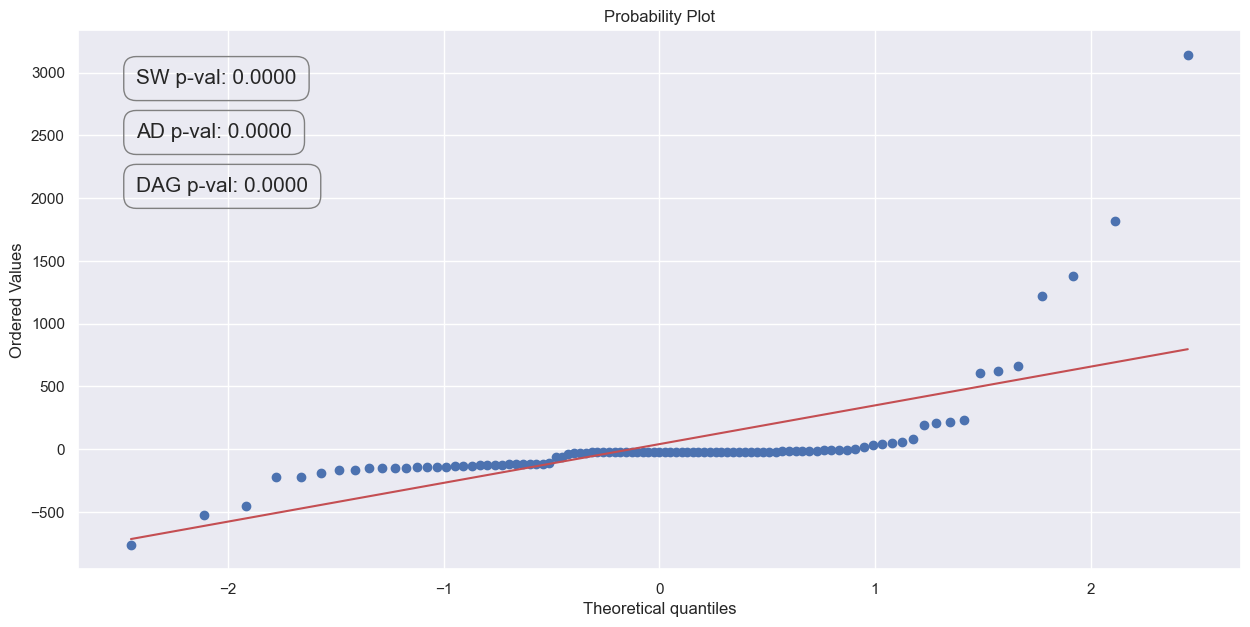

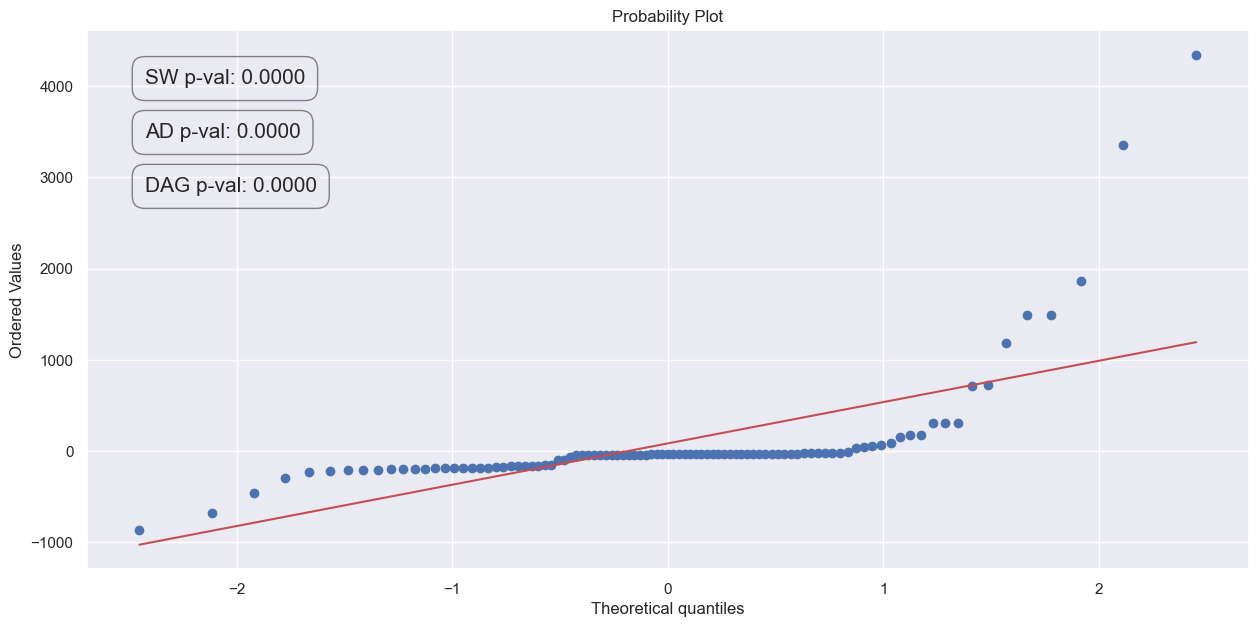

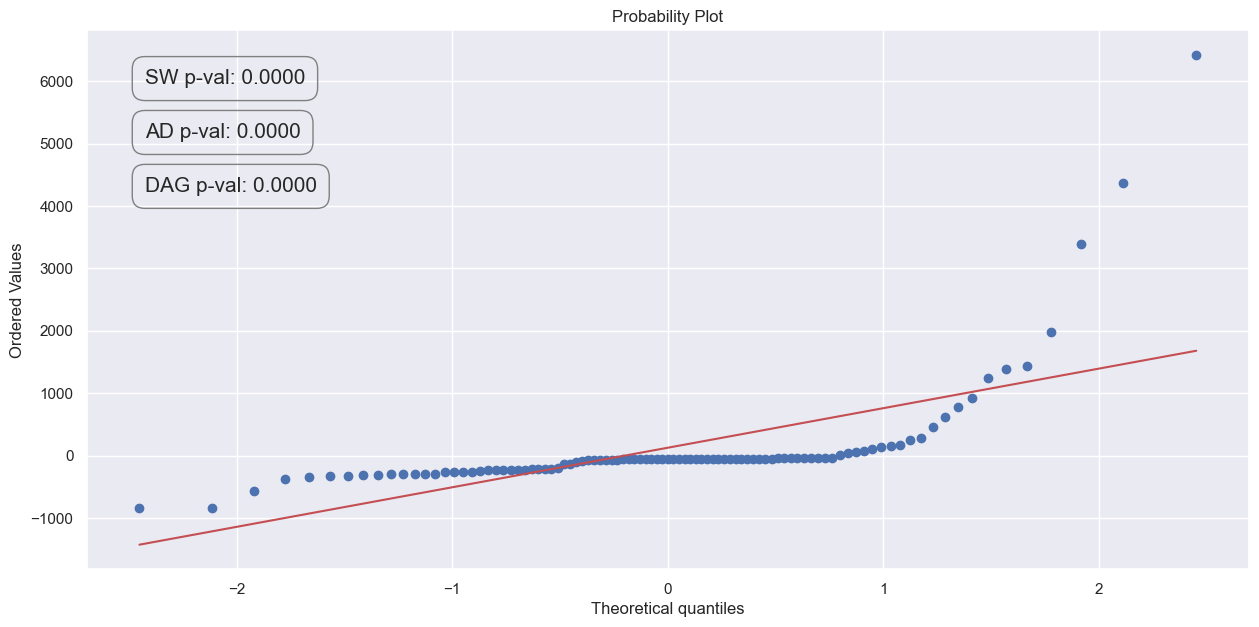

In [35]:
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats

for column in list(residuals.columns[-4:]):
    sw_result = stats.shapiro(residuals[column])
    ad_result = normal_ad(np.array(residuals[column]), axis=0)
    dag_result = stats.normaltest(residuals[column], axis=0, nan_policy='propagate')

    plt.figure(figsize=(15,7))
    res = stats.probplot(residuals[column], plot=plt)
    ax = plt.gca()
    ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

    plt.show()